# Import libraries

In [1]:
# numpy, scipy, pandas, sklearn, matplotlib
import numpy as np
import pandas as pd
from scipy.stats import entropy
from sklearn.metrics import accuracy_score,classification_report,roc_auc_score,RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# pytorch and pytorch lightning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision 
from torchvision import datasets
import torchvision.transforms as transforms
!pip install torchsummary
from torchsummary import summary
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# others
import os
from tqdm import tqdm_notebook as tqdm
import time
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
# print("Number of workers:", NUM_WORKERS)

Device: cuda:0


In [3]:
# global constants
IMAGE_SIZE = (224, 224)
NUM_CLASSES = 3
BATCH_SIZE = 32

# Import data

In [4]:
# define image transformation when importing data
def images_transforms_original(training = False):
    if training:
        data_transformation = transforms.Compose([
            transforms.Resize(IMAGE_SIZE),
            # transforms.RandomEqualize(10),
            transforms.RandomRotation(degrees = 15),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
    else:
        data_transformation = transforms.Compose([
            transforms.Resize(IMAGE_SIZE),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
        
    
    return data_transformation

In [5]:
# dataset path
train_path = '../input/covid19-image-dataset/Covid19-dataset/train'
val_path = '../input/covid19-image-dataset/Covid19-dataset/test'
deploy_path = '../input/covid19radiographydatabaseedited/COVID-19_Radiography_Dataset'

# import data
trainset_original = datasets.ImageFolder(train_path,transform=images_transforms_original(training = True))
valset_original = datasets.ImageFolder(val_path,transform=images_transforms_original())
deployset_original = datasets.ImageFolder(deploy_path,transform=images_transforms_original())

# reduce size of deployment data (for computational time and memory)
n_deployment = 800
deploy_idx = np.random.choice(len(deployset_original.targets), size=n_deployment, replace=False)
deployset_original = Subset(deployset_original, deploy_idx)

print("Training set size: {}\nValidation set size: {}\nDeployment set size: {}".format(len(trainset_original.targets),len(valset_original.targets),n_deployment))
print(trainset_original.class_to_idx)


Training set size: 251
Validation set size: 66
Deployment set size: 800
{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}


# Original model

In [6]:
class Original(pl.LightningModule):
    def __init__(self, lr, weight_decay, num_classes = NUM_CLASSES, pretrained_model = None, max_epochs=10):
        super().__init__()
        self.save_hyperparameters()
        self.model = pretrained_model if pretrained_model is not None else torchvision.models.resnet50(pretrained=True)  # Output of last linear layer: 2048-dim representation
        if pretrained_model is None:
            self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        
    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                            T_max=self.hparams.max_epochs,
                                                            eta_min=self.hparams.lr/50) # search what does it refer to
        return [optimizer], [lr_scheduler]

    def crossentropy_loss(self, batch, mode='train'):
        images, labels = batch
        outputs = self.model(images)
        loss = F.cross_entropy(outputs, labels)
        self.log(mode+'_loss', loss)
        return loss

    def training_step(self, batch, batch_idx):
        return self.crossentropy_loss(batch, mode='train')
    
    def validation_step(self, batch, batch_idx):
        self.crossentropy_loss(batch, mode='val')

In [7]:
def train_original(train_loader, val_loader, batch_size=32, pretrained_model=None, max_epochs=10, **kwargs):
    trainer = pl.Trainer(gpus=1 if str(device)=='cuda:0' else 0,
                         max_epochs=max_epochs,
                         callbacks=[pl.callbacks.progress.TQDMProgressBar()],
                         log_every_n_steps=batch_size)
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    pl.seed_everything(42) # To be reproducable
    model = Original(pretrained_model=pretrained_model, max_epochs=max_epochs, **kwargs)
    trainer.fit(model, train_loader, val_loader)
    model = Original.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    return model

In [8]:
# hyperparameters
LR = 1e-3
WD = 1e-4

# DataLoader
train_loader_original = DataLoader(trainset_original,batch_size=BATCH_SIZE,shuffle=True,num_workers=4)
val_loader_original = DataLoader(valset_original,batch_size=BATCH_SIZE,shuffle=False,num_workers=4)
deploy_loader_original = DataLoader(deployset_original,batch_size=BATCH_SIZE,shuffle=False,num_workers=4)

original_model = train_original(train_loader=train_loader_original,
                            val_loader=val_loader_original,
                            batch_size=BATCH_SIZE,
                            lr=LR,
                            weight_decay=WD)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [9]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

# Self-supervised learning

In [10]:
class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, *datasets, transforms=None):
        self.datasets = datasets
        self.transforms = transforms

    def __getitem__(self, i):
        # print(self.__len__())
        try:
            ds_position = 0
            item = None
            while ds_position < len(self.datasets):
                if i < self.datasets[ds_position].__len__():
                    if self.transforms is not None:
                        item = (self.transforms(self.datasets[ds_position].__getitem__(i)[0]),
                           int(self.datasets[ds_position].__getitem__(i)[1]))
                    else:
                        item = (self.datasets[ds_position].__getitem__(i)[0], int(self.datasets[ds_position].__getitem__(i)[1]))
                    break
                else:
                    i -= self.datasets[ds_position].__len__()
                    ds_position += 1
            assert item is not None
            return item
        except:
            print("The function failed to get the item.")

    def __len__(self):
        return sum([self.datasets[i].__len__() for i in range(len(self.datasets))])

In [11]:
class ContrastiveTransformations(object):

    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]

In [12]:
contrast_transforms = transforms.Compose([transforms.ToPILImage(),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.RandomResizedCrop(size=224), # can change size
                                          transforms.RandomApply([
                                              transforms.ColorJitter(brightness=0.8,
                                                                     contrast=0.8,
                                                                     saturation=0.8,
                                                                     hue=0.2)
                                          ], p=0.8),
                                          transforms.RandomGrayscale(p=0.2),
                                          transforms.GaussianBlur(kernel_size=9), # can change kernel size
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                         ])

In [13]:
# global variable for storing val_loss and val_acc_top5 (since Tensorboard doesn't work on Kaggle)
train_loss_list = []
val_loss_list = []
val_acc_top5_list = []

In [14]:
class SimCLR(pl.LightningModule):

    def __init__(self, hidden_dim, lr, temperature, weight_decay, pretrained_model=None, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'
        # Base model f(.)
        self.model = pretrained_model if pretrained_model is not None else torchvision.models.resnet50(pretrained=True)  # Output of last linear layer: 2048-dim representation
        # print("Hi\n{}".format(list(self.model.children())))
        # The MLP for g(.) consists of Linear->ReLU->Linear
        # print(self.model.fc)
        # print(len(list(list(self.model.children())[-1].children())))
        # print(list(self.model.children())[-1])
        # print(list(list(self.model.children())[-1].children()))
        if len(list(list(self.model.children())[-1].children())) == 0:
            self.model = nn.Sequential(*(list(self.model.children())[:-1]),
                                        nn.Flatten(),
                                        nn.Linear(self.model.fc.in_features, 2048),
                                        nn.ReLU(inplace=True),
                                        nn.Linear(2048, hidden_dim))
            # print("done")
        # print("Hihi\n{}".format(list(self.model.children())))
    
    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                            T_max=self.hparams.max_epochs,
                                                            eta_min=self.hparams.lr/50) # search what does it refer to
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode='train'):
        imgs, _ = batch
        # print(imgs.shape)
        imgs = torch.cat(imgs, dim=0)
        # print(imgs.shape)

        # Encode all images
        feats = self(imgs)
        # print(feats.shape)
        # Calculate cosine similarity
        cos_sim = F.cosine_similarity(feats[:,None,:], feats[None,:,:], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        # print(mode+'_loss: {:.4f}'.format(nll))
        self.log(mode+'_loss', nll)
        # Get ranking position of positive example
        comb_sim = torch.cat([cos_sim[pos_mask][:,None],  # First position positive example
                              cos_sim.masked_fill(pos_mask, -9e15)],
                             dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(mode+'_acc_top1', (sim_argsort == 0).float().mean())
        self.log(mode+'_acc_top5', (sim_argsort < 5).float().mean())
        self.log(mode+'_acc_mean_pos', 1+sim_argsort.float().mean())
        if mode == 'val':
            val_loss_list.append(nll.item())
            val_acc_top5_list.append((sim_argsort < 5).float().mean().item())
        elif mode == "train":
            train_loss_list.append(nll.item())
        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='val')

In [15]:
def train_simclr(train_loader, val_loader, batch_size, pretrained_model=None, max_epochs=500, **kwargs):
    trainer = pl.Trainer(gpus=1 if str(device)=='cuda:0' else 0,
                         max_epochs=max_epochs,
                         callbacks=[pl.callbacks.progress.TQDMProgressBar(), pl.callbacks.ModelCheckpoint(mode='max', monitor="val_acc_top5")],
                         log_every_n_steps=batch_size)
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need
    
    pl.seed_everything(42) # To be reproducable
    model = SimCLR(pretrained_model=pretrained_model, max_epochs=max_epochs, **kwargs)
    trainer.fit(model, train_loader, val_loader)
    model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    return model

In [16]:
# hyperparameters
HIDDEN_DIM = 128
LR = 1e-3
TEMP = 0.07
WD = 1e-4

ssrset_train_ratio = 0.8
MAX_EPOCHS = 250
    
# import data
ssr_transformation = transforms.Compose([transforms.Resize(IMAGE_SIZE), transforms.ToTensor()])
trainset_ssr = datasets.ImageFolder(train_path,transform = ssr_transformation)
valset_ssr = datasets.ImageFolder(val_path,transform = ssr_transformation)
deployset_ssr = datasets.ImageFolder(deploy_path,transform = ssr_transformation)
deployset_ssr = Subset(deployset_ssr, deploy_idx)
    
ssrset = ConcatDataset(trainset_ssr, valset_ssr, deployset_ssr, transforms = ContrastiveTransformations(contrast_transforms, n_views=2))
# ssr_loader = DataLoader(ssrset,batch_size=batch_size,shuffle=False,num_workers=4)
train_idx = np.random.choice(ssrset.__len__(), size=int(ssrset.__len__()*ssrset_train_ratio), replace=False)
ssrset_train = Subset(ssrset, train_idx)
ssrset_val = Subset(ssrset, [i for i in range(ssrset.__len__()) if i not in train_idx])
# print(ssrset_train.__len__(), ssrset_val.__len__())
ssr_train_loader = DataLoader(ssrset_train,batch_size=BATCH_SIZE,shuffle=True,num_workers=4)
ssr_val_loader = DataLoader(ssrset_val,batch_size=BATCH_SIZE,shuffle=False,num_workers=4)

simclr_model = train_simclr(train_loader=ssr_train_loader,
                            val_loader=ssr_val_loader,
                            batch_size=BATCH_SIZE,
                            hidden_dim=HIDDEN_DIM,
                            lr=LR,
                            temperature=TEMP,
                            weight_decay=WD,
                            pretrained_model=original_model.model,
                            max_epochs=MAX_EPOCHS)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

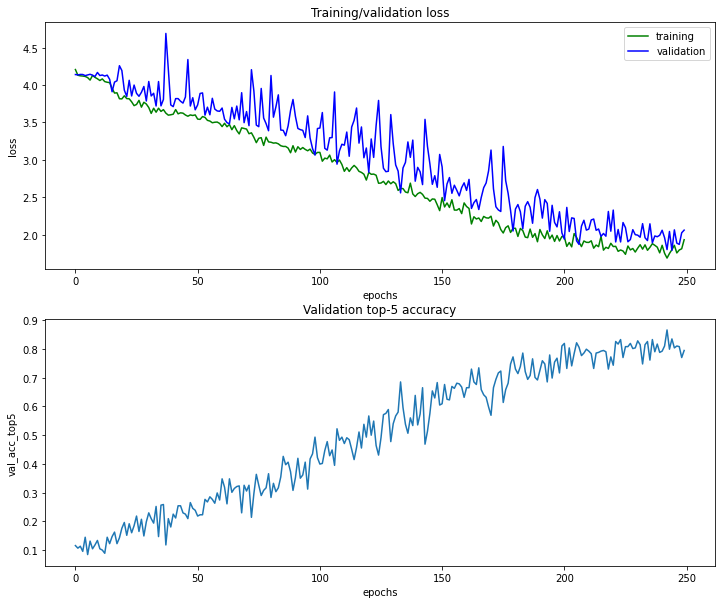

In [17]:
for _ in range(2):
    val_loss_list.pop(0)
    val_acc_top5_list.pop(0)
train_loss_matrix = np.reshape(train_loss_list, (MAX_EPOCHS, -1))
val_loss_matrix = np.reshape(val_loss_list, (MAX_EPOCHS, -1))
val_acc_top5_matrix = np.reshape(val_acc_top5_list, (MAX_EPOCHS, -1))

r_train = ssrset_train.__len__() % BATCH_SIZE
weights_train = np.ones(train_loss_matrix.shape[1]) * BATCH_SIZE / ssrset_train.__len__()
if r_train != 0:
    weights_train[-1] = r_train / ssrset_train.__len__()
assert abs(np.sum(weights_train)-1) < 1e-5
train_loss_list = np.dot(train_loss_matrix, weights_train)
r_val = ssrset_val.__len__() % BATCH_SIZE
weights_val = np.ones(val_loss_matrix.shape[1]) * BATCH_SIZE / ssrset_val.__len__()
if r_val != 0:
    weights_val[-1] = r_val / ssrset_val.__len__()
assert abs(np.sum(weights_val)-1) < 1e-5
val_loss_list = np.dot(val_loss_matrix, weights_val)
val_acc_top5_list = np.dot(val_acc_top5_matrix, weights_val)

plt.figure(figsize=(12, 10))
plt.subplot(211)
plt.plot(train_loss_list, color="green", label="training")
plt.plot(val_loss_list, color="blue", label="validation")
plt.title("Training/validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.subplot(212)
plt.plot(val_acc_top5_list)
plt.title("Validation top-5 accuracy")
plt.xlabel("epochs")
plt.ylabel("val_acc_top5")
plt.show()

In [18]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

Reusing TensorBoard on port 6006 (pid 599), started 4:23:30 ago. (Use '!kill 599' to kill it.)